In [1]:
import os
import os.path as osp
import shutil

from PIL import Image
from glob import glob
import torch
import torch.nn as nn
import gc
import numpy as np
import fetal_monitor
from fetal_monitor.models.resnet import (ResidualBlock,
                                         ResNet)
from fetal_monitor.dataset.dataloader import data_loader
from fetal_monitor.utils.utils import calc_auc
from torch.utils.data import (Dataset, 
                              DataLoader, 
                              ConcatDataset,
                              random_split)
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

from sklearn import svm, metrics
from sklearn.metrics import auc, roc_curve, RocCurveDisplay
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

/home/sangwon/anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### draw auc ###

patient_id : 11977062
patient_id : 11632775
patient_id : 12144707
patient_id : 12206951
c_val_dataset size :  555
--------------------Test : 0 fold --------------------
Cross Validation Fold Number : 0 | Accuracy : 0.9369369369369369 %
Cross Validation Fold Number : 0 | AUC-ROC : 0.8035714285714286 %
--------------------Test : 1 fold --------------------
Cross Validation Fold Number : 1 | Accuracy : 0.9144144144144144 %
Cross Validation Fold Number : 1 | AUC-ROC : 0.7692307692307692 %
--------------------Test : 2 fold --------------------
Cross Validation Fold Number : 2 | Accuracy : 0.9309309309309309 %
Cross Validation Fold Number : 2 | AUC-ROC : 0.969626168224299 %
--------------------Test : 3 fold --------------------
Cross Validation Fold Number : 3 | Accuracy : 0.9301801801801802 %
Cross Validation Fold Number : 3 | AUC-ROC : 0.9101941747572815 %
--------------------Test : 4 fold --------------------
Cross Validation Fold Number : 4 | Accuracy : 0.9423423423423424 %
Cross Validat

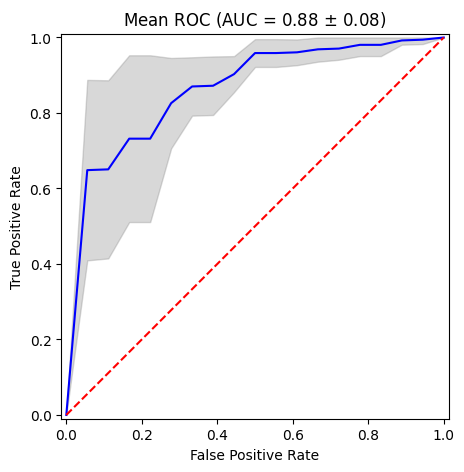

In [2]:
CROSSVAL = [11977062, 12144707, 12206951, 11632775]
CROSSVAL_BASKET = list()

resize_scala = 224
num_classes = 2

# def main(model_path):
model_path = "/home/sangwon/sources/resnet/tools/20230316-142628/best_model_ep17.pt"
model_path = "/home/sangwon/sources/resnet/tools/20230316-235202/best_model_ep52.pt"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(ResidualBlock, [3, 2, 6, 3], num_classes)
model = torch.load(model_path)
model.eval()
results_graph, results_auc = list(), list()

tprs = []
aucs = []
base_fpr = np.linspace(0, 1, 19)

plt.figure(figsize=(5, 5))
plt.axes().set_aspect('equal', 'datalim')

for patient_id_path in glob(f'/home/sangwon/sources/resnet/tools/data/*Data*0313*/*'):
    patient_id = int(osp.basename(patient_id_path))
    if patient_id in CROSSVAL:
        print(f'patient_id : {patient_id}')
        _dataset = ImageFolder(root=patient_id_path,
                               transform=transforms.Compose([transforms.Resize([resize_scala, resize_scala]),
                                                             transforms.ToTensor(),
                                                            ]))
        CROSSVAL_BASKET.append(_dataset)

if (len(CROSSVAL_BASKET) == len(CROSSVAL)):
    c_val_dataset = ConcatDataset(CROSSVAL_BASKET)
else:
    raise Exception(f'There should be patient ids omitted!')

# Test : 5-fold
total = 0
correct = 0
total_auc_roc = 0
cnt = 0
print('c_val_dataset size : ', len(c_val_dataset))
for idx, c_val_fold in enumerate(random_split(c_val_dataset,
                                              [int(len(c_val_dataset)/5) for idx in range(5)], 
                                              generator=torch.Generator().manual_seed(42))
                                ):

    print(f'--------------------Test : {idx} fold --------------------')
    fold_batch_size = int(len(c_val_dataset)/5)
    # fold_batch_size = batch_size
    c_val_loader = DataLoader(c_val_fold,
                              batch_size=fold_batch_size,
                              shuffle=True,
                              num_workers=4)
    # Validation
    with torch.no_grad():
        for loader_idx, item in enumerate(c_val_loader):
            images = item[0]
            labels = item[1]
            images = images.to(device)
            labels = labels.to(device)
            if torch.all(labels.bool()): 
                print(f'{idx} valid loader is skipped!')
                continue
            cnt += 1
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print('Cross Validation Fold Number : {} | Accuracy : {} %'.format(idx, correct / total))

            outputs_sf_max = outputs.softmax(dim=1)
            probability = outputs_sf_max[:, 1].cpu().detach().numpy()
            labels_np = labels.cpu().detach().numpy()

            fpr, tpr, _ = roc_curve(labels_np, probability, pos_label=1)
            auc_roc = metrics.auc(fpr, tpr)
            aucs.append(auc_roc)
            # plt.plot(fpr, tpr, 'b', alpha=0.15)
            tpr = np.interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)
            print('Cross Validation Fold Number : {} | AUC-ROC : {} %'.format(idx, auc_roc))

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std_tprs = tprs.std(axis=0)

aucs = np.array(aucs)
mean_aucs = aucs.mean(axis=0)
std_aucs = aucs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std_tprs, 1)
tprs_lower = mean_tprs - std_tprs

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_aucs, std_aucs))
plt.savefig('final.png', dpi=100)
plt.show()

In [3]:
# Data Prep
'''
from PIL import Image
for sub_dir in glob('./data/fetal_monitor_20220110/*'):
    for animg in glob(f'{sub_dir}/*'):        
        tmpImg = Image.open(f'{animg}')
        tmpImg = tmpImg.resize((224, 224))
        _path = animg.replace("fetal_monitor_20220110", 
                              "fetal_monitor_20220110_resized_224")
        if not osp.exists(osp.dirname(_path)):
            os.makedirs(osp.dirname(_path))

        tmpImg.save(f'{_path}')
'''

# to delete 애매한 것
'''
cwd = os.getcwd()

for a_dir in glob(f'{cwd}/data/*Data*0313*/*/*'):
    if ('╛╓╕┼╟╤ ░═' in a_dir):
        dir_del = a_dir
        shutil.rmtree(dir_del)
        assert os.path.exists(dir_del) == False, f'{dir_del} still exist!'
        continue
    if ('Normal' not in a_dir) and ('Abnormal' not in a_dir):
        shutil.rmtree(dir_del)
        assert os.path.exists(dir_del) == False, f'{dir_del} still exist!'
'''

"\ncwd = os.getcwd()\n\nfor a_dir in glob(f'{cwd}/data/*Data*0313*/*/*'):\n    if ('╛╓╕┼╟╤ ░═' in a_dir):\n        dir_del = a_dir\n        shutil.rmtree(dir_del)\n        assert os.path.exists(dir_del) == False, f'{dir_del} still exist!'\n        continue\n    if ('Normal' not in a_dir) and ('Abnormal' not in a_dir):\n        shutil.rmtree(dir_del)\n        assert os.path.exists(dir_del) == False, f'{dir_del} still exist!'\n"

### dataloader ###

### fetal data ###

In [4]:
# PIL usage
'''
from PIL import Image

img = Image.open("/home/sangwon/sources/resnet/tools/tmp/fetal/fetal_mon.png")
# from IPython import display
# display.Image("/home/sangwon/sources/resnet/tools/tmp/fetal/fetal_mon.png")
print(img.width, img.height)
width, height = img.size

left = 0; top = 0; right = width; bottom = 2*height / 4
mom = (left, top, right, bottom)

# Cropped image of above dimension
# (It will not change original image)
mom = img.crop(mom)
mom_resize = mom.resize((224, 224))
left = 0; top = (3*height/4); right = width; bottom = height
baby = (left, top, right, bottom)

baby = img.crop(baby)
baby_resize = baby.resize((224, 224))

# convert image to tensor
convcustom_mimetypeert_tensor = transforms.ToTensor()
fetal_img = convert_tensor(img)
print(fetal_img.shape)
'''

'\nfrom PIL import Image\n\nimg = Image.open("/home/sangwon/sources/resnet/tools/tmp/fetal/fetal_mon.png")\n# from IPython import display\n# display.Image("/home/sangwon/sources/resnet/tools/tmp/fetal/fetal_mon.png")\nprint(img.width, img.height)\nwidth, height = img.size\n\nleft = 0; top = 0; right = width; bottom = 2*height / 4\nmom = (left, top, right, bottom)\n\n# Cropped image of above dimension\n# (It will not change original image)\nmom = img.crop(mom)\nmom_resize = mom.resize((224, 224))\nleft = 0; top = (3*height/4); right = width; bottom = height\nbaby = (left, top, right, bottom)\n\nbaby = img.crop(baby)\nbaby_resize = baby.resize((224, 224))\n\n# convert image to tensor\nconvcustom_mimetypeert_tensor = transforms.ToTensor()\nfetal_img = convert_tensor(img)\nprint(fetal_img.shape)\n'

### traing loop + test ###

In [3]:
TRAIN = [10450555,10657486,11057045,
         12120541,11661895,11762836,
         11781242,12059111,12241130,
         12130784,12168164,12177066,
         12182543,12189365,12218436,
         12227047,12230344,12250517,
         12257489,12258685,12261155,
         12240224,12239771]

VAL = [12273756,12231373]

CROSSVAL = [11977062, 12144707, 12206951, 11632775]


In [4]:
res = list()
for pid in TRAIN+CROSSVAL:
    setsize = len(glob(f'./data/Data_0313/{pid}/Abnormal/*'))
    res.append([pid, setsize])
    

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper Parameters
num_epochs = 1
num_classes = 2
learning_rate = 0.002
resize_scala = 224
batch_size = 32

# train loader
cwd = os.getcwd()
TRAIN_BASKET, VAL_BASKET, CROSSVAL_BASKET = list(), list(), list()

for patient_id_path in glob(f'{cwd}/data/*Data*0313*/*'):
    patient_id = int(osp.basename(patient_id_path))
    if patient_id in TRAIN:
        _dataset = ImageFolder(root=patient_id_path,
                               transform=transforms.Compose([transforms.Resize([resize_scala, resize_scala]),
                                                             transforms.ToTensor(),
                                                            ]))
        TRAIN_BASKET.append(_dataset)
        
    elif patient_id in VAL:
        _dataset = ImageFolder(root=patient_id_path,
                               transform=transforms.Compose([transforms.Resize([resize_scala, resize_scala]),
                                                             transforms.ToTensor(),
                                                            ]))
        VAL_BASKET.append(_dataset)
        
    elif patient_id in CROSSVAL:
        _dataset = ImageFolder(root=patient_id_path,
                               transform=transforms.Compose([transforms.Resize([resize_scala, resize_scala]),
                                                             transforms.ToTensor(),
                                                            ]))
        CROSSVAL_BASKET.append(_dataset)
    else:
        raise Exception(f'{patient_id} not included in any group!')

if (len(TRAIN_BASKET) == len(TRAIN) and \
    len(VAL_BASKET) == len(VAL) and \
    len(CROSSVAL_BASKET) == len(CROSSVAL)):
    
    train_dataset = ConcatDataset(TRAIN_BASKET)
    valid_dataset = ConcatDataset(VAL_BASKET)
    c_val_dataset = ConcatDataset(CROSSVAL_BASKET)
else:
    raise Exception(f'There should be patient ids omitted!')

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(valid_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

# c_val_loader = DataLoader(c_val_dataset,
#                           batch_size=batch_size,
#                           shuffle=True,
#                           num_workers=4)


### pixel mean substraction ###

In [3]:
'''
# pixel_mean
pixel_basket = [ np.array(Image.open(an_img)) \
                for an_img in glob("./data/Data_0313/*/*/*.JPG") ]
pixel_mean = np.mean(pixel_basket, axis=0)
pixel_mean = pixel_mean.astype(np.uint8)

for an_img in glob("./data/Data_0313/*/*/*.JPG"):
    _subt_img = np.array(Image.open(an_img)) - pixel_mean
    dir_path = osp.dirname(an_img)
    dest_dir_path = dir_path.replace('Data_0313', 'data_subtraction')
    if not osp.exists(dest_dir_path):
        os.makedirs(dest_dir_path, exist_ok=True)
        abnor_dest_dir_path = dest_dir_path.replace('Normal', 'Abnormal')
            
    file_name = an_img.replace('Data_0313', 'data_subtraction')
    # _subt_img to IMG
    final_img = Image.fromarray(_subt_img.astype(np.uint8))
    final_img.save(file_name)

for a_sub in glob("./data/data_subtraction/*"):
    _search = glob(f"{a_sub}/*")
    if len(_search) == 1:
        if not "Normal" in _search[0]:
            __dest = _search[0].replace('Abnormal', 'Normal')
            os.makedirs(__dest, exist_ok=True)
        elif not "Abnormal" in _search[0]:
            __dest = _search[0].replace('Normal', 'Abnormal')
            os.makedirs(__dest, exist_ok=True)
'''

(array([ 88,  88,  88, ..., 967, 967, 967]), array([120, 120, 120, ..., 367, 367, 367]), array([0, 1, 2, ..., 0, 1, 2]))
(1004, 1300, 3)
uint8


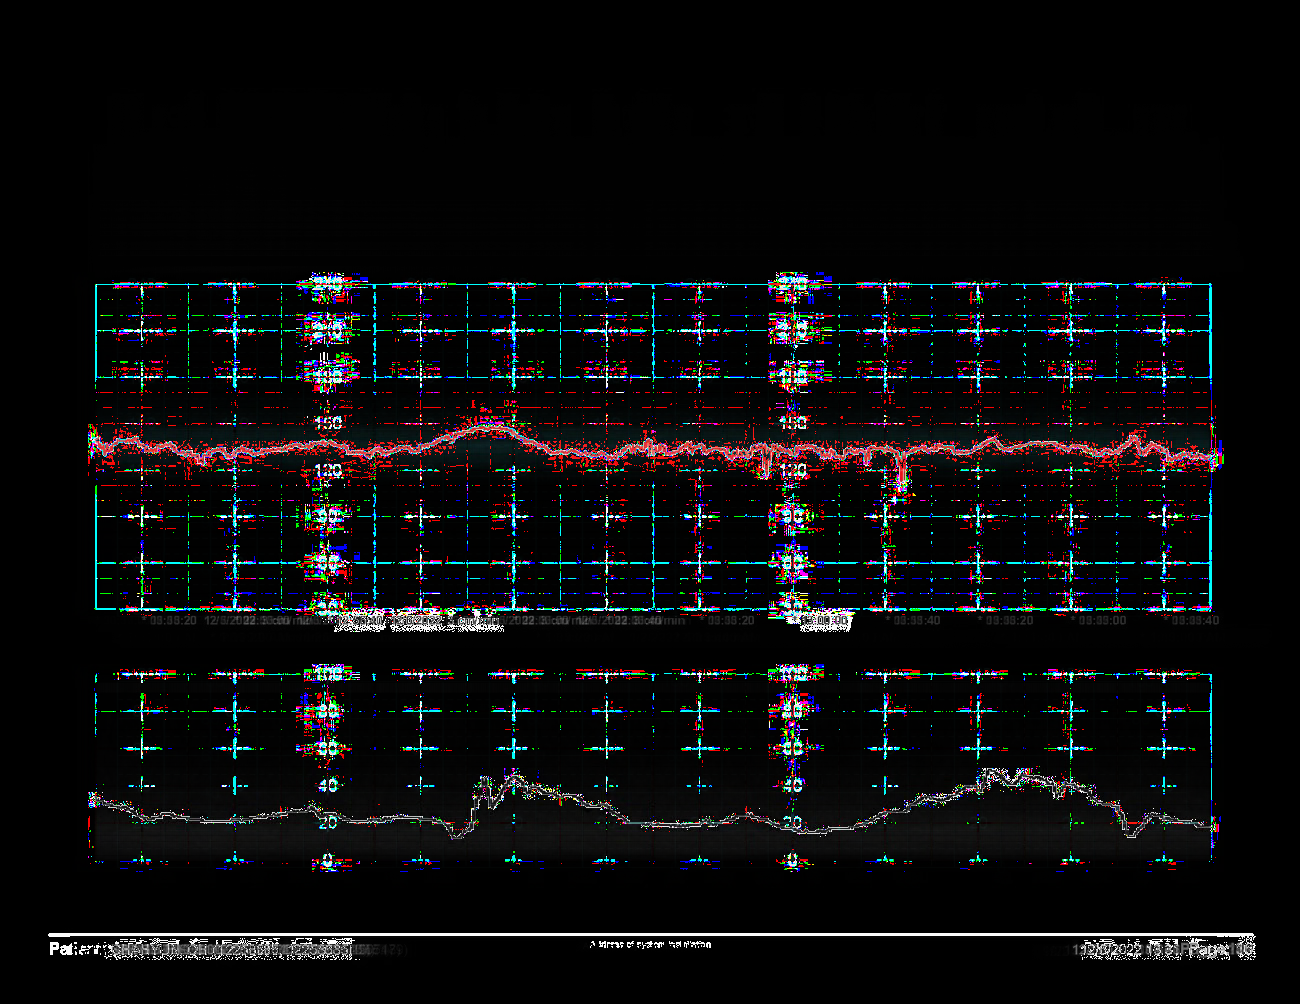

In [88]:
sample_img = "data/Data_0313/10450555/Normal/003-F0024901001045055520221206145038240003.JPG"
substr_res = np.array(Image.open(sample_img)) - pixel_mean
print(np.nonzero(substr_res))
print(substr_res.shape)
print(substr_res.dtype)
final_img = Image.fromarray(_subt_img.astype(np.uint8))
final_img 


In [48]:
pic_path = "data/Data_0313/10450555/Normal/003-F0024901001045055520221206145038240003.JPG"
pic_array = np.array(Image.open(pic_path))
pic_array.dtype


dtype('uint8')

In [27]:
'''
meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_dataset]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_dataset]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])
print("평균",meanR, meanG, meanB)
print("표준편차",stdR, stdG, stdB)

# train data, test data 다르게 nomalization 적용하려면 data_dir 바꾸세요.
# data_dir = "train"
# get_mean_std(data_dir)
'''

'\nmeanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_dataset]\nstdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_dataset]\n\nmeanR = np.mean([m[0] for m in meanRGB])\nmeanG = np.mean([m[1] for m in meanRGB])\nmeanB = np.mean([m[2] for m in meanRGB])\n\nstdR = np.mean([s[0] for s in stdRGB])\nstdG = np.mean([s[1] for s in stdRGB])\nstdB = np.mean([s[2] for s in stdRGB])\nprint("평균",meanR, meanG, meanB)\nprint("표준편차",stdR, stdG, stdB)\n\n# train data, test data 다르게 nomalization 적용하려면 data_dir 바꾸세요.\n# data_dir = "train"\n# get_mean_std(data_dir)\n'

In [ ]:
# Test : 5-fold
total = 0
correct = 0
total_auc_roc = 0
cnt = 0
print('c_val_dataset size : ', len(c_val_dataset))
for idx, c_val_fold in enumerate(random_split(c_val_dataset,
                                              [int(len(c_val_dataset)/5) for idx in range(5)], 
                                              generator=torch.Generator().manual_seed(42))
                                ):

    print(f'--------------------Test : {idx} fold --------------------')
    fold_batch_size = int(len(c_val_dataset)/5)
    # fold_batch_size = batch_size
    c_val_loader = DataLoader(c_val_fold,
                              batch_size=fold_batch_size,
                              shuffle=True,
                              num_workers=4)
    # Validation
    with torch.no_grad():
        for loader_idx, item in enumerate(c_val_loader):
            images = item[0]
            labels = item[1]
            images = images.to(device)
            labels = labels.to(device)
            if torch.all(labels.bool()): 
                print(f'{idx} valid loader is skipped!')
                continue
            cnt += 1
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print('Cross Validation Fold Number : {} | Accuracy : {} %'.format(idx, correct / total))

            outputs_sf_max = outputs.softmax(dim=1)
            probability = outputs_sf_max[:, 1].cpu().detach().numpy()
            labels_np = labels.cpu().detach().numpy()
            print(f'model output probability : {probability}')

            fprs, tprs, thresholds = roc_curve(labels_np, probability, pos_label=1)
            auc_roc = metrics.auc(fprs, tprs)
            total_auc_roc = total_auc_roc + auc_roc
            if not osp.exists(f'./{timestr}'):
                os.mkdir(f'./{timestr}')
            fname = os.path.join(f'./{timestr}/', f'{epoch}_epoch_{idx}_fold_auc_roc.png')
            save_auc_roc_fig(fname, label=labels_np, predict=probability)
            print(f'Cross Validation Fold Number : {idx} | auc_roc: {auc_roc}') 


In [6]:
len(c_val_dataset)

555

In [33]:
# model
model = ResNet(ResidualBlock, [3, 2, 6, 3], num_classes).to(device)
        # in_channels, out_channels, stride = 1, downsample = None

# Optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate, 
                            weight_decay = 0.001, 
                            momentum = 0.9)
# Train
for epoch in range(num_epochs):
    print(f'--------------------Train--------------------')
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        class_weights = compute_class_weight(class_weight='balanced',
                                             classes=np.unique(labels.cpu().detach().numpy()),
                                             y=labels.cpu().detach().numpy())
        class_weights = torch.Tensor(class_weights)

        # Forward pass
        outputs = model(images)
        # criterion = nn.CrossEntropyLoss() # origin
        criterion_weighted = nn.CrossEntropyLoss(weight=class_weights.to(device))
        loss = criterion_weighted(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}'
                .format(epoch+1, num_epochs, loss.item()))



--------------------Train--------------------


RuntimeError: weight tensor should be defined either for all 2 classes or no classes but got weight tensor of shape: [1] at /opt/conda/conda-bld/pytorch_1603729047590/work/aten/src/THCUNN/generic/ClassNLLCriterion.cu:44

In [ ]:
# model
model = ResNet(ResidualBlock, [3, 2, 6, 3], num_classes).to(device)
               # in_channels, out_channels, stride = 1, downsample = None

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate, 
                            weight_decay = 0.001, 
                            momentum = 0.9)
# Train
for epoch in range(num_epochs):
    print(f'--------------------Train--------------------')
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}'
                .format(epoch+1, num_epochs, loss.item()))


'''
    # Validation
    with torch.no_grad():
        print(f'--------------------Valid--------------------')
        correct = 0
        total = 0
        total_auc_roc = 0
        for idx, item in enumerate(valid_loader):
            images = item[0]
            labels = item[1]
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # print('Validation Set Number : {} | Accuracy : {} %'.format(idx, correct / total))

            outputs_sf_max = outputs.softmax(dim=1)
            probability = outputs_sf_max[:, 1].cpu().detach().numpy()
            labels_np = labels.cpu().detach().numpy()

            fprs, tprs, thresholds = roc_curve(labels_np, probability, pos_label=1)
            auc_roc = metrics.auc(fprs, tprs)
            total_auc_roc = total_auc_roc + auc_roc
            # print(f'fprs: {fprs} | tprs : {tprs} | auc_roc: {auc_roc}')

            del images, labels, outputs

    # Test : 5-fold
    total = 0
    correct = 0
    total_auc_roc = 0
    cnt = 0
    for idx, c_val_fold in enumerate(random_split(c_val_dataset,
                                            [int(len(c_val_dataset)/5) for idx in range(5)], 
                                            generator=torch.Generator().manual_seed(42))
                                    ):

        print(f'--------------------Test : {idx} fold --------------------')
        fold_batch_size = int(len(c_val_dataset)/5)
        # fold_batch_size = batch_size
        c_val_loader = DataLoader(c_val_fold,
                                  batch_size=fold_batch_size,
                                  shuffle=True,
                                  num_workers=4)
        # Validation
        with torch.no_grad():
            for loader_idx, item in enumerate(c_val_loader):
                images = item[0]
                labels = item[1]
                images = images.to(device)
                labels = labels.to(device)
                if torch.all(labels.bool()): 
                    print(f'{idx} valid loader is skipped!')
                    continue
                cnt += 1
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                print('Cross Validation Fold Number : {} | Accuracy : {} %'.format(idx, correct / total))

                outputs_sf_max = outputs.softmax(dim=1)
                probability = outputs_sf_max[:, 1].cpu().detach().numpy()
                labels_np = labels.cpu().detach().numpy()
                print(f'model output probability : {probability}')

                fprs, tprs, thresholds = roc_curve(labels_np, probability, pos_label=1)
                auc_roc = metrics.auc(fprs, tprs)
                total_auc_roc = total_auc_roc + auc_roc
                fname = f'./{epoch}_epoch_{idx}_fold_auc_roc.png'
                save_auc_roc_fig(fname, label=labels_np, predict=probability)
                print(f'Cross Validation Fold Number : {idx} | auc_roc: {auc_roc}') 

                del images, labels, outputs

    report_loss = loss.cpu().detach().numpy()
    average_accuracy = correct / total
    avg_auc_roc = total_auc_roc / cnt
    # report_doc = {'default': float(report_loss),
    #               'average accuracy': float(average_accuracy),
    #               'avg auc roc': float(avg_auc_roc)}


# Train
for epoch in range(num_epochs):
    print(f'--------------------Train--------------------')
    for i, (images, labels) in enumerate(train_loader):        
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, loss.item()))

    # Validation
    with torch.no_grad():
        print(f'--------------------Valid--------------------')
        correct = 0
        total = 0
        for idx, item in enumerate(valid_loader):
            images = item[0]
            labels = item[1]
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            print('Validation # : {} | Accuracy : {} %'.format(idx, correct / labels.size(0)))
            print('AUC-ROC : {} %'.format(calc_auc(predicted.cpu().detach().numpy(), labels.cpu().detach().numpy())))
        
            del images, labels, outputs            

    # Test : 5-fold
    for idx, c_val_fold in enumerate(random_split(c_val_dataset, 
                                             [int(len(c_val_dataset)/5) for idx in range(5)], 
                                             generator=torch.Generator().manual_seed(42))
                                    ):
        print(f'--------------------Test : {idx} fold --------------------')
        fold_batch_size = int(len(c_val_dataset)/5)
        # fold_batch_size = batch_size
        c_val_loader = DataLoader(c_val_fold,
                                  batch_size=fold_batch_size,
                                  shuffle=True,
                                  num_workers=4)
        # Validation
        with torch.no_grad():
            correct = 0
            total = 0
            for idx, item in enumerate(c_val_loader):
                images = item[0]
                labels = item[1]
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                print('Validation # : {} | Accuracy : {} %'.format(idx, correct / labels.size(0)))
                print('AUC-ROC : {} %'.format(calc_auc(predicted.cpu().detach().numpy(), labels.cpu().detach().numpy())))

                del images, labels, outputs
'''


In [14]:
# for idx, item in enumerate(valid_loader):
#             images = item[0]
#             labels = item[1]

a = torch.rand(1, 2).bool()
a
# tensor([[False, True]], dtype=torch.bool)
torch.all(a)
# tensor(False, dtype=torch.bool)
# a = torch.arange(0, 3)
# a
# tensor([0, 1, 2])
# torch.all(a)

tensor(True)

In [24]:
# torch.cat((labels), 0.0)
tmp_res = torch.cat( (labels, torch.Tensor([0]) ), 0 )



'''
tensor([[ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497],
        [ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497],
        [ 0.6580, -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497]])
torch.cat((x, x, x), 1)
'''

'\ntensor([[ 0.6580, -1.0969, -0.4614],\n        [-0.1034, -0.5790,  0.1497],\n        [ 0.6580, -1.0969, -0.4614],\n        [-0.1034, -0.5790,  0.1497],\n        [ 0.6580, -1.0969, -0.4614],\n        [-0.1034, -0.5790,  0.1497]])\ntorch.cat((x, x, x), 1)\n'

In [ ]:
import matplotlib.pyploy as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name = f"Resnet vs the rest",
    color = "darkblue",
)
plt.plot([0,1], [0,1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.savefig(fname, *, dpi='figure', 
            format=None, metadata=None, bbox_inches=None, 
            pad_inches=0.1, facecolor='auto', edgecolor='auto',
            backend=None)

In [ ]:
dataset = ConcatDataset([dataset_train_part, dataset_test_part])

train_loader = DataLoader(dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=2)

# test loader
dataset = ImageFolder(root='data/fetal_monitor_20220110_resized_224',
                      transform=transforms.Compose([transforms.ToTensor(),                                                   
                                                   ]))
test_batch_size = int(len(glob(f'{folder}/*.JPG')))
test_loader = DataLoader(dataset,
                         batch_size=test_batch_size,
                         shuffle=True,
                         num_workers=2)

# model
model = ResNet(ResidualBlock, [3, 2, 6, 3], num_classes).to(device) 
# in_channels, out_channels, stride = 1, downsample = None

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate, 
                            weight_decay = 0.001, 
                            momentum = 0.9)  

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        print(images.shape)
        print(labels)
        
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print('Epoch [{}/{}], Loss: {:.4f}'
          .format(epoch+1, num_epochs, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for idx, item in enumerate(test_loader):
            images = item[0]
            labels = item[1]
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            print(f'IDX : {idx}')
            print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))
            print('AUC-ROC : {} %'.format(calc_auc(predicted.cpu().detach().numpy(), labels.cpu().detach().numpy())))
        
            del images, labels, outputs
